In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sklearn as sk
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
import argparse
import os

import matplotlib.pyplot as plt
%matplotlib inline

# structure of code largely based on tensorflow tutorial for deep neural nets: https://www.tensorflow.org/get_started/mnist/pros
# see full code of tutorial here: https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_deep.py

In [2]:
## Utility functions

def sign(x, threshold=0):
    y = x > threshold
    return y.astype(int)

def get_data_filenames(data_dir, data_file_ext, assay_name):
    '''
    Returns dictionary mapping 'train', 'test', and 'score' to the corresponding data filename
    '''
    return {subfolder: os.path.join(os.getcwd(), data_dir, subfolder, '') + assay_name + '.' + data_file_ext \
            for subfolder in ['train', 'test', 'score']}

def read_file(filename):
    '''
    Parameters
    - filename: str
        File must be tab-delimited as follows: smiles code, tox21_id, label, fingerprint
    
    Returns
    - (X, Y): tuple of np.arrays
        X is an array of features
        Y is a vector of labels
    '''
    X = []
    Y = []
    input_file = open(filename, 'r')
    
    for index, line in enumerate(input_file):
        # split line (1 data point) into smiles, fingerprint (features), and label
        split_line = line.strip().split('\t')
        # print(index)
        # smiles = split_line[0]
        fingerprint = [int(c) for c in split_line[3]]
        label = int(split_line[2])
        
        # append data point to train_x (features) and train_y (labels)
        X.append(fingerprint)
        Y.append(label)
    input_file.close()
    return (np.array(X), np.array(Y))

In [3]:
## if running inside iPython notebook

# parameters
rand_seed = 848
run_id = 1
assay_name = 'nr-ahr'
data_dir = 'fingerprints'
data_file_ext = 'fp'
loss_balance = True
scale = 0.1
batch_size = 50
num_epochs = 3
node_array = np.array([512, 256, 128])

# get data
filenames = get_data_filenames(data_dir, data_file_ext, assay_name)
X_train, Y_train = read_file(filenames['train'])
X_test, Y_test = read_file(filenames['test'])
X_score, Y_score = read_file(filenames['score'])
num_features = X_train.shape[1]

In [4]:
## Model - basic ##

# Notes
# Probability of classifying into the positive class = sigmoid(logit)
# logit can take on any real value

def deepnn_params(x, nodes, scale=0.1):
    """
    deepnn builds the graph for a deep net for learning the logit

    Args:
        x: input layer. type = tf.Tensor. size = (batch_size, num_features)
        nodes: a list of number of nodes in hidden layers. type = np.ndarray
        scale: L2 regularization weights. type = float

    Returns:
        y: a tensor of length batch_size with values equal to the logits
            of classifying an input data point into the positive class
    """
    # tensorflow dense layer example: https://www.tensorflow.org/tutorials/layers#dense_layer
    
    layers = []
    layers.append(x)
    
    num_hidden_layers = min(nodes.size,nodes[0])
    for i in range(num_hidden_layers):
        layers.append(tf.layers.dense(inputs=layers[i], units=nodes[i], activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale)))
    layers.append(tf.layers.dense(inputs=layers[num_hidden_layers], units=1, activation=None, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale)))
    return tf.squeeze(layers[-1])

# sign tensorflow function
def sign_tf(x, threshold=0):
    return tf.cast(tf.greater_equal(x, threshold), tf.int32)

# input
x = tf.placeholder(tf.float32, [None, num_features])

# labels
y_labels = tf.placeholder(tf.float32, [None]) # domain: {0,1}

# loss weights for unbalanced data
q = tf.placeholder(tf.float32, None)

# Build the graph for the deep net
y_score = deepnn_params(x, node_array, scale)
y_prob = tf.sigmoid(y_score)

# Define loss and optimizer
# logistic loss, aka sigmoid cross entropy
# y * -log(sigmoid(x)) + (1 - y) * -log(1 - sigmoid(x)), where x is the logit and y is the label
loss_fn = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(targets=y_labels, logits=y_score, pos_weight=q))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss_fn)

correct_prediction = tf.equal(sign_tf(y_score), tf.cast(y_labels, tf.int32))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [5]:
## Train model ##

np.random.seed(rand_seed)

# calculate frequencies of positives, negatives in training set
# - https://stackoverflow.com/questions/35155655/loss-function-for-class-imbalanced-binary-classifier-in-tensor-flow
q_train = Y_train.size/np.sum(Y_train)
q_test = Y_test.size/np.sum(Y_test)
print('q_train: %0.3g \t q_test: %0.3g' % (q_train, q_test))
if not loss_balance:
    q_train = 1

# training parameters
num_batches_per_epoch = int(np.ceil(len(X_train) / batch_size))
print("Number of batches per epoch: %d " % num_batches_per_epoch)

# keep track of loss and accuracy
train_losses = []
train_accs = []
test_losses = []
test_accs = []
track_iter = []
track_freq = 50

sess = tf.InteractiveSession()
tf.set_random_seed(rand_seed)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# accuracy based on initialized weights
test_accuracy, test_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_test, y_labels: Y_test, q: q_train})
train_accuracy, train_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_train, y_labels: Y_train, q: q_train})
test_accs.append(test_accuracy)
test_losses.append(test_loss)
train_accs.append(train_accuracy)
train_losses.append(train_loss)
track_iter.append(0)

# tensorflow model save location
model_savepath = os.path.join(os.getcwd(), '') + 'deepnn_model_weights' + str(run_id) + '.ckpt'
saver.save(sess, model_savepath)
print('initial test accuracy %0.3g' % test_accuracy)
print('initial test loss %0.3g' % test_loss)

# training loop
for epoch in range(num_epochs):
    # shuffle indices of training data
    shuffle_indices = np.arange(X_train.shape[0])
    np.random.shuffle(shuffle_indices)

    for i in range(num_batches_per_epoch):
        # get batch
        batch_indices = shuffle_indices[i*batch_size : (i+1)*batch_size]
        batch_x = X_train[batch_indices]
        batch_y = Y_train[batch_indices]

        # train on batch data
        sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y, q: q_train})

        # store loss and accuracy
        if i % track_freq == 0 or i == num_batches_per_epoch-1:
            test_accuracy, test_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_test, y_labels: Y_test, q: q_train})
            train_accuracy, train_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_train, y_labels: Y_train, q: q_train})
            test_accs.append(test_accuracy)
            test_losses.append(test_loss)
            train_accs.append(train_accuracy)
            train_losses.append(train_loss)
            track_iter.append(epoch*num_batches_per_epoch+i+1)
            print('step %d, \t train loss: %0.3g,\t test loss: %0.3g,\t train acc: %0.3g,\t test acc: %0.3g\t' % (i, train_loss, test_loss, train_accuracy, test_accuracy))

            # save variables only if accuracy has increased
            if test_accuracy > max(test_accs):
                saver.save(sess, model_savepath)

print("Best test accuracy: %0.3g" % max(test_accs))

q_train: 8.58 	 q_test: 9.03
Number of batches per epoch: 163 
initial test accuracy 0.129
initial test loss 1.29
step 0, 	 train loss: 1.29,	 test loss: 1.28,	 test acc: 0.173	
step 50, 	 train loss: 0.982,	 test loss: 1.1,	 test acc: 0.557	
step 100, 	 train loss: 0.847,	 test loss: 1.08,	 test acc: 0.579	
step 150, 	 train loss: 0.801,	 test loss: 1.02,	 test acc: 0.697	
step 162, 	 train loss: 0.782,	 test loss: 1.1,	 test acc: 0.587	
step 0, 	 train loss: 0.787,	 test loss: 1.12,	 test acc: 0.565	
step 50, 	 train loss: 0.738,	 test loss: 1.04,	 test acc: 0.661	
step 100, 	 train loss: 0.714,	 test loss: 1.16,	 test acc: 0.576	
step 150, 	 train loss: 0.67,	 test loss: 1.07,	 test acc: 0.657	
step 162, 	 train loss: 0.714,	 test loss: 1.29,	 test acc: 0.542	
step 0, 	 train loss: 0.706,	 test loss: 1.27,	 test acc: 0.542	
step 50, 	 train loss: 0.639,	 test loss: 1.08,	 test acc: 0.642	
step 100, 	 train loss: 0.655,	 test loss: 0.993,	 test acc: 0.712	
step 150, 	 train loss: 0.5

Text(0.5,1,'Training loss versus SGD iteration')

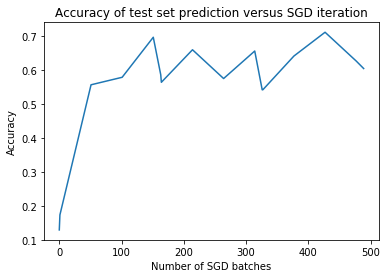

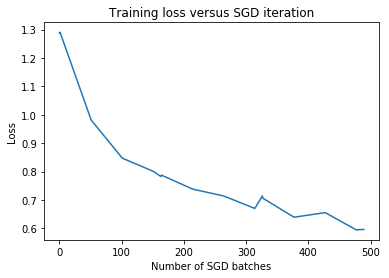

In [6]:
# Plot accuracy of test set prediction
plt.figure()
plt.plot(track_iter, test_accs)
plt.xlabel('Number of SGD batches')
plt.ylabel('Accuracy')
plt.title('Accuracy of test set prediction versus SGD iteration')

# Plot training loss
plt.figure()
plt.plot(track_iter, train_losses)
plt.xlabel('Number of SGD batches')
plt.ylabel('Loss')
plt.title('Training loss versus SGD iteration')

Final scoring accuracy: 0.735
Final confusion matrix: 
[[379 156]
 [  5  68]] 

AUC: 0.873


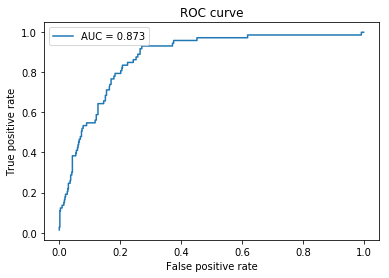

In [7]:
## AUROC - sklearn

# get normalized score, i.e. probability of classifying into positive class
y_prob_score = sess.run(y_prob, feed_dict={x: X_score})
score_accuracy = sess.run(accuracy, feed_dict={x: X_score, y_labels: Y_score})
print('Final scoring accuracy: %0.3g' % score_accuracy)
print('Final confusion matrix: ')
print(sk.metrics.confusion_matrix(Y_score, sign(y_prob_score, 0.5)), '\n')

fpr, tpr, thresholds = sk.metrics.roc_curve(Y_score, y_prob_score)
auc_roc = sk.metrics.auc(fpr, tpr)
print('AUC: %0.3g' % auc_roc)

plt.figure()
plt.plot(fpr, tpr, label='AUC = ' + str(round(auc_roc, 3)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()

# for t in thresholds:
#     prediction = sign(score, t)
#     c = sk.metrics.confusion_matrix(Y_val, prediction)
#     print(c)

In [8]:
## Compute the saliency map

# Compute the score of the correct class for each example.
# This gives a Tensor with shape [N], the number of examples.
correct_scores = y_labels*y_prob + (1-y_labels)*(1-y_prob)

# Gradient of the scores with respect to the input features x
grads_fun = tf.gradients(correct_scores, x)[0]

# Final saliency map has shape (size_training_data, num_features)
saliency_vecs = sess.run(grads_fun, feed_dict={x: X_train, y_labels: Y_train})

<Container object of 881 artists>

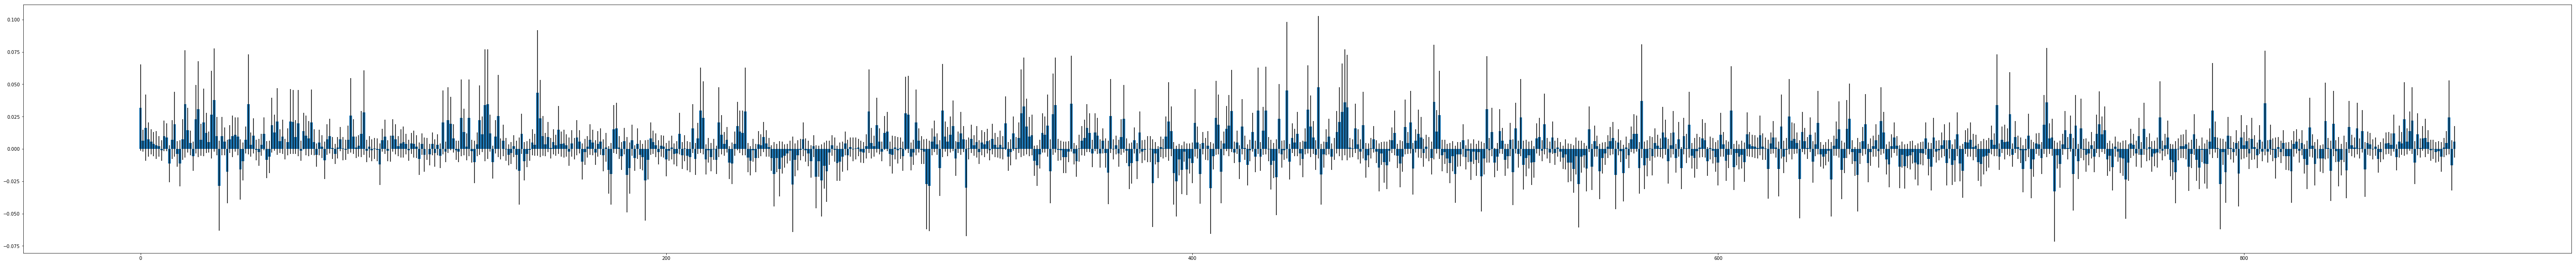

In [9]:
# bar plot (mean + sample standard deviation) of saliency of all features
# see here for meaning of features: ftp://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.txt
mean_saliency = np.mean(saliency_vecs, axis=0)
stddev_saliency = np.std(saliency_vecs, axis=0, ddof=1)
plt.figure(figsize=(100,10))
plt.bar(range(881), mean_saliency, width=1, yerr=stddev_saliency)

Text(0.5,1,'Top 10 predictive features for non-toxicity')

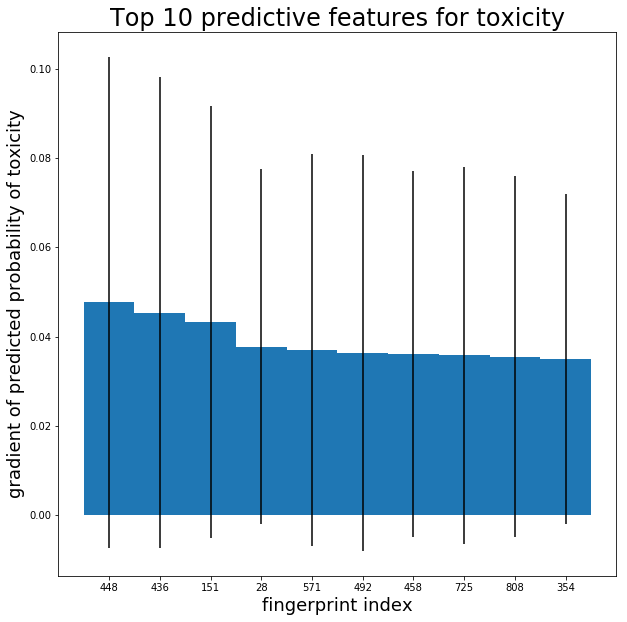

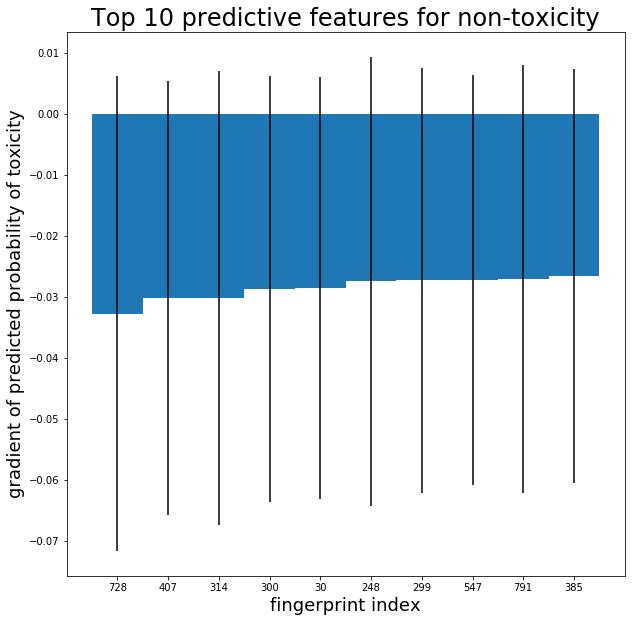

In [10]:
# bar plot (mean + sample standard deviation) of saliency of top n features
n_top = 10
n_bottom = 10
mean_saliency = np.mean(saliency_vecs, axis=0)
stddev_saliency = np.std(saliency_vecs, axis=0, ddof=1)

idx_sort = np.argsort(mean_saliency)

top_ind = idx_sort[-n_top:][::-1]
top_val = mean_saliency[top_ind]
top_std = stddev_saliency[top_ind]

plt.figure(figsize=(10,10))
plt.bar(range(n_top), top_val, width=1, yerr=top_std, tick_label=top_ind)
plt.xlabel('fingerprint index', fontsize='18')
plt.ylabel('gradient of predicted probability of toxicity', fontsize='18')
plt.title('Top 10 predictive features for toxicity', fontsize='24')

bottom_ind = idx_sort[0:n_bottom]
bottom_val = mean_saliency[bottom_ind]
bottom_std = stddev_saliency[bottom_ind]

plt.figure(figsize=(10,10))
plt.bar(range(n_bottom), bottom_val, width=1, yerr=bottom_std, tick_label=bottom_ind)
plt.xlabel('fingerprint index', fontsize='18')
plt.ylabel('gradient of predicted probability of toxicity', fontsize='18')
plt.title('Top 10 predictive features for non-toxicity', fontsize='24')